In [1]:
# encoding=utf-8
# author： s0mE
# subject： 人名以及关系提取
# date： 2019-06-26

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import jieba
import jieba.posseg as pseg

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
def count_names(fp, model):
    """
    统计文本中的所有名字，返回统计矩阵
    """
    #逐行提取名字
    name_set = set()
    cut_result = []
    with open(fp,"r") as f:
        lines = f.readlines()
        for ith, line in enumerate(lines):
            if ith % 100 == 0: # 显示处理进度
                print("Processing:{:.5f}".format(ith*1.0/len(lines)))
            
            words = model.cut(line)
            line_dict = {} 
            
            for word,flag in words:
                if flag == "np" or flag == "nr" or flag == "j":
                    # 如果 word 是人名，加入人名的统计中
                    line_dict[word] = line_dict.get(word,0) + 1
                    name_set.add(word)
            if len(line_dict) != 0: 
                cut_result.append(line_dict)
    # 名字关系矩阵计算
    names = list(name_set)  # 所有名字的列表
    name_arr = np.zeros((len(names), len(cut_result)),dtype=np.int32)  # 储存统计结果的数组
    for n, n_dict in enumerate(cut_result):
            for k,v in n_dict.items():
                i = names.index(k)
                name_arr[i,n] += v
    # 计算人名的关系矩阵
    rel = np.zeros((len(names), len(names)), dtype=np.int32)
    for i in range(len(names)):
        rel[i,:] = np.sum(name_arr[:,name_arr[i,:]>0],axis=1)

    ########至此，已经初步完成了文章的人物关系统计##############
    ############ 不过这里仍然有很多问题   ###################
    #### 例如明显的错误名字，以及同一人物不同的别称需要进一步处理 ###
    ################需要后续的处理 #######################
    return rel,names


In [3]:
def filter_names(rel, names, trans={}, err=[], threshold=0):
    """对结果进行精细的调整与过滤

    处理顺序: 转换 ==> 去错 ==> 过滤 ==> 排序

    Args:
        rel:关系矩阵 n x n
        names: 人名向量矩阵 n
        trans: 别称转换字典 将别称转换为统一名字
        err: 错误名称矩阵 要删除的错误名称列表
        threshold: 词频阈值 词频低于此阈值的名字会被过滤，等于0（default）时使用词频均值自动过滤，等于-1不过滤
    
    Returns:
        rel_filter
        names_filter
        过滤好的人名矩阵和名称矩阵
    """

    # 名字的转换与计数的合并
    if len(trans)!=0:
        name_new = list(set(names) - set(trans.keys()))  # 转换后的名字
        indexes = [list(names).index(n) for n in name_new]
        for i, name in enumerate(names):
            if name in trans.keys():
                new_i = list(names).index(trans[names[i]])
                rel[new_i, :] += rel[i, :]
                rel[:, new_i] += rel[:, i]
        names = np.array(name_new)
        rel = rel[indexes,:][:,indexes]

    # 去错
    if len(err)!=0:
        name_new = list(set(names)-set(err)) #去错后的名字列表
        indexes = [list(names).index(n) for n in name_new]
        names = np.array(name_new)
        rel = rel[indexes,:][:,indexes]

    # 过滤掉低频的名字
    if threshold != -1:
        if threshold ==0:
            rel_threshold = max(rel.diagonal().mean(), threshold)
        else:
            rel_threshold = threshold
        rel_filter = np.diag(rel) > rel_threshold
        names = names[rel_filter]
        rel = rel[rel_filter, :][:, rel_filter]

    # 人名排序
    indexes = np.argsort(np.diag(rel))[::-1]  # 从大到小
    names = names[indexes]
    rel = rel[indexes, :][:, indexes]

    return rel,names


In [4]:
jieba.load_userdict("weicheng_dict.txt")

fp = "围城.txt"
model = pseg  

rels, ns = count_names(fp, model)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.767 seconds.
Prefix dict has been built successfully.


Processing:0.00000
Processing:0.04433
Processing:0.08865
Processing:0.13298
Processing:0.17730
Processing:0.22163
Processing:0.26596
Processing:0.31028
Processing:0.35461
Processing:0.39894
Processing:0.44326
Processing:0.48759
Processing:0.53191
Processing:0.57624
Processing:0.62057
Processing:0.66489
Processing:0.70922
Processing:0.75355
Processing:0.79787
Processing:0.84220
Processing:0.88652
Processing:0.93085
Processing:0.97518


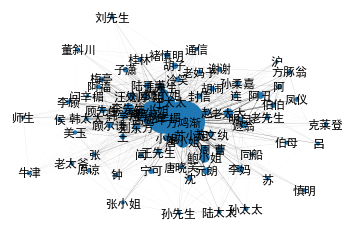

In [5]:
trans_dict = {
    "鸿渐": "方鸿渐",
    "辛楣": "赵辛楣",
    "赵先生": "赵辛楣"
}

relations,names = filter_names(rels,ns,trans=trans_dict,err=[],threshold=0)

G = nx.Graph()
sizes = np.diag(relations)
G.add_nodes_from(names)
weights = []
for i in range(len(names)):
    for j in range(i+1,len(names)):
        G.add_edge(names[i],names[j],weight=relations[i,j])
        weights.append(relations[i,j])

plt.subplot(111)
weights = np.array(weights)
weights = weights*5.0/np.max(weights)
nx.draw(G, with_labels=True, node_size=sizes,width=weights)
plt.show()
